# INFO 2950: Phase 2 
#### Group Members: Anusha Bishayee, Katheryn Ding

---
### __Research Question:__  

#### How do ESG score and stock performance (price) align across different industries? What associations can we find between company industry, stock performance, and ESG ratings?
#### note: ESG score refers to a quantiative metric measuring a company's environmental, social, and governance performance; 'environmental' pertains to aspects like waste management and energy emissions, 'social' pertains to aspects like customer satisfaction and DEI in the workplace, and 'governance' pertains to aspects like operating efficiencies and risk management. ESG scores are typically examined by independent investors, business analysts, and even competitior companies to assess risk or opportunities associated with a specific company's practices.



---
### __Data Collection and Cleaning:__

In [1]:
import contextlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
import sys
import warnings
import yfinance as yf

our original dataset with ESG information for different large/mid-cap companies came in a csv format, which we downloaded from Kaggle. this had about 722 rows, each corresponding to a unique publicly traded company. further description of the columns here can be found in the 'Dataset Description' portion of this notebook.

we first dropped all rows that had null values, which eliminated 27 companies. we then filtered this dataset for just USD currency, excluding companies that are traded in CNY or any other currency. this allows us to have greater familiarity with the industries and companies we analyze - this process eliminated 15 more of our rows, and left us with 680 companies.

In [2]:
esg = pd.read_csv("esg_data.csv")
print(f"original data shape: {esg.shape}")

esg = esg.dropna()
print(f"non-null data shape: {esg.shape}")

esg = esg[esg["currency"] == "USD"]
print(f"refined data shape: {esg.shape}")

original data shape: (722, 21)
non-null data shape: (695, 21)
refined data shape: (680, 21)


then, we converted the 'last_processing_date' column in our dataset to DateTime format - a lot of rows had a differing date formats as well, so we had to convert them all to m/d/y. after that, we sorted the dataset by ascending and descending 'last_processing_date' to see the range of processing dates in the data. 

In [3]:
esg["last_processing_date"] = pd.to_datetime(esg["last_processing_date"], format = "mixed")
esg["last_processing_date"] = esg["last_processing_date"].dt.strftime('%m-%d-%Y')

esg = esg.sort_values(by = "last_processing_date", ascending = False)
print(f"latest dates:\n{esg["last_processing_date"].head(2)}")

esg = esg.sort_values(by = "last_processing_date", ascending = True)
print(f"\nearliest dates:\n{esg["last_processing_date"].head(2)}")

latest dates:
720    11-15-2022
716    11-15-2022
Name: last_processing_date, dtype: object

earliest dates:
658    02-08-2022
36     04-16-2022
Name: last_processing_date, dtype: object


after this, we realized we have two 'Energy' values for the 'industry' column - one is 'Energy ' and one is 'Energy'. we renamed all the 'Energy ' values, and also re-formatted some other industry column values.

In [6]:
esg['industry'] = esg['industry'].replace('Energy ', 'Energy')
esg['industry'] = esg['industry'].replace('Hotels, Restaurants & Leisure', 'Hotels, Restaurants, & Leisure')
esg['industry'] = esg['industry'].replace('Hotels Restaurants and Leisure', 'Hotels, Restaurants, & Leisure')
esg['industry'] = esg['industry'].replace('Consumer products', 'Consumer Products')
esg['industry'] = esg['industry'].replace('Logistics and Transportation', 'Logistics & Transportation')
esg['industry'] = esg['industry'].replace('Life Sciences Tools and Services', 'Life Sciences Tools & Services')
esg['industry'] = esg['industry'].replace('Commercial Services and Supplies', 'Commercial Services & Supplies')
esg['industry'] = esg['industry'].replace('Road and Rail', 'Road & Rail')
esg['industry'] = esg['industry'].replace('Metals and Mining', 'Metals & Mining')
esg['industry'] = esg['industry'].replace('Aerospace and Defense', 'Aerospace & Defense')
esg['industry'] = esg['industry'].replace('Textiles Apparel and Luxury Goods', 'Textiles, Apparel, & Luxury Goods')
esg['industry'] = esg['industry'].replace('Trading Companies and Distributors', 'Trading Companies & Distributors')


print(esg['industry'].unique())

['Leisure Products' 'Semiconductors' 'Health Care' 'Chemicals'
 'Telecommunication' 'Consumer Products' 'Airlines' 'Insurance'
 'Communications' 'Building' 'Technology' 'Logistics & Transportation'
 'Biotechnology' 'Banking' 'Pharmaceuticals' 'Financial Services'
 'Life Sciences Tools & Services' 'Electrical Equipment' 'Real Estate'
 'Machinery' 'Retail' 'Food Products' 'Industrial Conglomerates'
 'Hotels, Restaurants, & Leisure' 'Utilities' 'Beverages' 'Tobacco'
 'Media' 'Auto Components' 'Energy' 'Commercial Services & Supplies'
 'Packaging' 'Road & Rail' 'Metals & Mining'
 'Textiles, Apparel, & Luxury Goods' 'Trading Companies & Distributors'
 'Aerospace & Defense' 'Automobiles' 'Distributors'
 'Professional Services' 'Construction' 'Marine'
 'Diversified Consumer Services']


now, we wanted to add our finance data from the yfinance library onto to our esg dataset. we used the ticker column to match up companies from the yfinance library and our esg dataset, and we set our dates of the finance data to range from 2/1/21 to 12/31/22, as all of the 'last processing date' values for the esg data range from 2/8/22 to 11/15/22. in specific, we calculated a stock percentage change over this period for each company, a volatility index, a 50-day moving average, and a cumulative return metric.

In [7]:
# prevents some annoying yfinance outputs from printing
@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

tickers = esg["ticker"].tolist()
stock_data = []

for ticker in tickers:
    try:
        # suppresses all of the outputs when grabbing data from yfinance
        with suppress_output():  
            stock = yf.download(ticker, start = "2021-02-01", end = "2022-12-31", progress = False)
        
        if not stock.empty:
            # get closing price for 01/01/2021 and 12/31/2022
            close_2021_02_01 = stock.loc["2021-02-01"]["Close"] if "2021-02-01" in stock.index else None
            close_2022_12_31 = stock.loc["2022-12-30"]["Close"] if "2022-12-30" in stock.index else None

            # calculating percentage change
            percentage_change = ((stock["Close"].iloc[-1] - stock["Close"].iloc[0]) / stock["Close"].iloc[0]) * 100
            
            # calculating volatility (sd of daily returns)
            daily_returns = stock["Close"].pct_change()
            volatility = daily_returns.std()
            
            # calculating 50-day moving average
            stock["50_day_SMA"] = stock["Close"].rolling(window=50).mean()
            sma_50_day = stock["50_day_SMA"].iloc[-1]
            
            # calculating cumulative return
            cumulative_return = (stock["Close"].iloc[-1] / stock["Close"].iloc[0]) - 1
            
            stock_data.append({
                'ticker': ticker, 
                'start_close': close_2021_02_01,
                'end_close': close_2022_12_31,
                'percentage_change': percentage_change,
                'volatility': volatility,
                '50_day_SMA': sma_50_day,
                'cumulative_return': cumulative_return
            })
            
    # also helps to suppress annoying outputs
    except (yf.YFTzMissingError, yf.YFPricesMissingError):
        pass 

now, we needed to convert the stock data we extracted from yfinance to a dataframe, so that we can merge it with our original esg dataframe.

In [8]:
stock_df = pd.DataFrame(stock_data)
merged_df = esg.merge(stock_df, on = 'ticker', how = 'left')
print(f"current data shape: {merged_df.shape}")
print(f"\n{merged_df.head()}")

current data shape: (680, 27)

  ticker                           name currency  \
0   poww                       Ammo Inc      USD   
1   acls       Axcelis Technologies Inc      USD   
2   achc  Acadia Healthcare Company Inc      USD   
3     cf     CF Industries Holdings Inc      USD   
4      t                       AT&T Inc      USD   

                        exchange           industry  \
0     NASDAQ NMS - GLOBAL MARKET   Leisure Products   
1     NASDAQ NMS - GLOBAL MARKET     Semiconductors   
2     NASDAQ NMS - GLOBAL MARKET        Health Care   
3  NEW YORK STOCK EXCHANGE, INC.          Chemicals   
4  NEW YORK STOCK EXCHANGE, INC.  Telecommunication   

                                                logo  \
0  https://static.finnhub.io/logo/8decc6ca0564a89...   
1  https://static.finnhub.io/logo/88b5f730-80df-1...   
2  https://static.finnhub.io/logo/4b6b2e5a4cfce5b...   
3  https://static.finnhub.io/logo/9b57a636-80eb-1...   
4  https://static.finnhub.io/logo/7d20269e-80

after that, we needed to drop any rows where the finance data join has left null values. this eliminates 80 more of our rows, leaving us with 600 companies.

In [9]:
merged_df = merged_df.dropna()
print(f"non-null finance data shape: {merged_df.shape}\n")

merged_df = merged_df.sort_values(by = "name", ascending = True)
print(merged_df.head)

non-null finance data shape: (600, 27)

<bound method NDFrame.head of     ticker                             name currency  \
71     mmm                            3M Co      USD   
142    aos                   A O Smith Corp      USD   
661   abvc               ABVC Biopharma Inc      USD   
17    acad       ACADIA Pharmaceuticals Inc      USD   
41    aciw                ACI Worldwide Inc      USD   
..     ...                              ...      ...   
500    zts                       Zoetis Inc      USD   
571    zuo                        Zuora Inc      USD   
643    zws  Zurn Elkay Water Solutions Corp      USD   
647   zyme                    Zymeworks Inc      USD   
189   ebay                         eBay Inc      USD   

                          exchange                  industry  \
71   NEW YORK STOCK EXCHANGE, INC.  Industrial Conglomerates   
142  NEW YORK STOCK EXCHANGE, INC.                  Building   
661     NASDAQ NMS - GLOBAL MARKET             Biotechnology   
1

this is still a lot of data, but will be helpful for getting industry-level and other general overviews of the data. merged_df will be our main dataset.

we also want to create a sample of these 600 companies so that we are able to look at trends and associations at individual company-level as well. to create our sample, we went through the industry list and selected 23 well-known companies from differing industries manually, however, we will probably refine this approach later (this ties into one of our questions for reviewers and limitations). sample_companies will be our 2nd dataset.

In [10]:
companies = ["Walt Disney Co", "American Airlines Group Inc", "Apple Inc", "eBay Inc", "Goldman Sachs Group Inc", 
             "Meta Platforms Inc", "Starbucks Corp", "PayPal Holdings Inc", "United Airlines Holdings Inc", 
             "Bath & Body Works Inc", "Abbvie Inc", "Alexandria Real Estate Equities Inc", 
             "Becton Dickinson and Co", "Brown & Brown Inc", "Duke Energy Corp", "T-Mobile US Inc",
             "Marathon Oil Corp", "Chipotle Mexican Grill Inc", "Target Corp", 
             "General Motors Co", "Salesforce Inc", "Tesla Inc", "Bank of America Corp"]

sample_companies = merged_df[merged_df["name"].isin(companies)]
print(sample_companies)

    ticker                                 name currency  \
161   abbv                           Abbvie Inc      USD   
147    are  Alexandria Real Estate Equities Inc      USD   
6      aal          American Airlines Group Inc      USD   
10    aapl                            Apple Inc      USD   
133    bac                 Bank of America Corp      USD   
660   bbwi                Bath & Body Works Inc      USD   
130    bdx              Becton Dickinson and Co      USD   
121    bro                    Brown & Brown Inc      USD   
86     cmg           Chipotle Mexican Grill Inc      USD   
273    duk                     Duke Energy Corp      USD   
235     gm                    General Motors Co      USD   
231     gs              Goldman Sachs Group Inc      USD   
508    mro                    Marathon Oil Corp      USD   
512   meta                   Meta Platforms Inc      USD   
362   pypl                  PayPal Holdings Inc      USD   
452    crm                       Salesfo

finally, we also extracted some general S&P 500 data from yfinance, ranging from the dates of 2/1/21 and 12/31/22 for the same reason. we are pulling this data so that we can compare stock performance of the individual companies to the overall S&P 500 in the same time range. sp500 will be our 3rd dataset.

In [11]:
sp500data = yf.download('^GSPC', start = '2021-02-01', end = '2022-12-31', progress = False)
sp500 = pd.DataFrame({
    'Date': sp500data.index,
    'Start Price': sp500data['Open'],
    'End Price': sp500data['Close'],
    'Rate of Change': ((sp500data['Close'] - sp500data['Open']) / sp500data['Open']) * 100 })

sp500.set_index('Date', inplace = True)
print(sp500)

            Start Price    End Price  Rate of Change
Date                                                
2021-02-01  3731.169922  3773.860107        1.144150
2021-02-02  3791.840088  3826.310059        0.909057
2021-02-03  3840.270020  3830.169922       -0.263005
2021-02-04  3836.659912  3871.739990        0.914339
2021-02-05  3878.300049  3886.830078        0.219942
...                 ...          ...             ...
2022-12-23  3815.110107  3844.820068        0.778745
2022-12-27  3843.340088  3829.250000       -0.366610
2022-12-28  3829.560059  3783.219971       -1.210063
2022-12-29  3805.449951  3849.280029        1.151771
2022-12-30  3829.060059  3839.500000        0.272650

[484 rows x 3 columns]


---
### __Data Description__

1) Where can your raw source data be found, if applicable? Provide a link to the raw data (hosted on Github, in a Cornell Google Drive or Cornell Box).

- We have 3 main datasets: 1 main dataset (merged_df), 1 "sample" dataset that selects 23 rows from this main dataset (sample_companies), and 1 additional dataset (sp500). Our raw data for the first 2 datasets can be found on Kaggle, here: https://github.com/anushabishayee/info2950_finalproject/blob/main/raw%20data/esg%20kaggle%20csv%20link and the actual csv is here: https://github.com/anushabishayee/info2950_finalproject/blob/main/esg_data.csv.
- Even more specifically, the Kaggle author states that they pulled the data for their csv from multiple APIs, like ESG Enterprise, a publicly-available API. They grabbed financial and company data from Finnhub. 3 of these links can be found here: https://github.com/anushabishayee/info2950_finalproject/blob/main/raw%20data/esg%20kaggle%20source%20data%20links.
- The finance data that the 3rd dataset is comprised of, and the finance data that is joined to the 1st and 2nd datasets is found in the yfinance library in Python (Yahoo Finance data, https://github.com/anushabishayee/info2950_finalproject/blob/main/raw%20data/yfinance%20links).

***

2) If people are involved, were they aware of the data collection and if so, what purpose did they expect the data to be used for? 

- Individuals are not involved in the data directly, as each observation corresponds to an entire company.

***

3) What preprocessing was done, and how did the data come to be in the form that you are using?

- Our preprocessing of these datasets is detailed above. Generally, we imported the yfinance library, downloaded the Kaggle csv with the company ESG data, cleaned the dataset for NaNs and unneeded values, and reformatted some date values for ease of manipulation. Then, we joined the ESG data to the yfinance stock data, matching on company ticker (we created 4 new stock metric columns), and dropped NaNs for the creation of merged_df. For the 2nd dataset (sample_companies), we filtered 23 specific companies from this main dataset. For the 3rd dataset, we extracted the data straight from the yfinance library, and calculated a rate of change variable for the stock change as well for sp500.
- For the Kaggle csv, the author notes that they used company stock ticker as a unique identifier, then pulled and collated data from various APIs. in specific, they utilized ESG Enterprise (https://www.esgenterprise.com/), a publicly-available API, and pulled their ratings methodology from https://app.esgenterprise.com/uploads/ESG-Enterprise-Risk-Ratings-MethodologyV3.pdf. They grabbed financial and company data from Finnhub (https://finnhub.io/). 

***

4) What processes might have influenced what data was observed and recorded and what was not?

- For the ESG data, the Kaggle author of the csv specifically mentioned that only mid/large-cap companies are included, so this influences the specific companies that are recorded in the initial data - smaller companies (that also might have an ESG score) will not be 'observed' here. The author pulled data from ESG Enterprise and Finnhub, so any companies that do not have data available there will not be observed in the dataset. We also dropped any company that had a NaN or blank column value for the ESG columns, and dropped any company that didn't have stock data available in Yahoo Finance (or had NaNs for any specific finance column).

***

5) Who funded the creation of the dataset?

- We created these 3 analysis-ready datasets from two data sources: a 'Public Company ESG Ratings Dataset' Kaggle dataset from user Alistair King (https://www.kaggle.com/alistairking), a New York-based Kaggle Datasets Grandmaster, as well as the yfinance Python library, created by Ran Aroussi (https://aroussi.com/) as a way around the 2017 Yahoo Finance API deprecation. It is unclear if these datasets were 'funded', but their organization and accumulation were spearheaded by the two aforementioned people, respectively.

***

6) Why was this dataset created? 
- We formulated our main analysis-ready dataset (merged_df) to examine associations between some of the largest USD-utilizing companies' ESG scores and their stock performances (as well as industry-specific analyses). Then, we formulated our sample dataset (sample_companies) so that we could take a look at some company-level analyses of the general data and research question (620 companies are kinda hard to visualize simultaneously). Finally, we formulated the sp500 dataset so that we could contrast company stock performance from the specified range of 2/1/21 - 12/31/22 to the overall performance of the S&P 500. (the rationale for the range of 2/1/21 - 12/31/22 is mentioned above, its due to the fact that most companies have a 'last processing date' of February 2022 - Novermber 2022 for their ESG score.) 
- The original ESG csv was created and uploaded by Kaggle user Alistair King, perhaps for personal enrichment or curiosity (they do have a Kaggle Datasets Grandmaster rank, so perhaps they just enjoy creating and uploading datasets). The original yfinance Python library was created by Ran Aroussi to have a simple way to download historical market data from Yahoo Finance, due to the Yahoo Finance API deprecation.

***

7) What are the observations (rows) and attributes (columns)?
- For the S&P 500 dataset (sp500), the rows each correspond to a specific date where the S&P 500 was measured, within the range from 2/1/21 - 12/31/22. The columns for this dataset are Start Price, End Price, and Rate of Change (aka the starting price of the S&P 500 when the US market opened on a specific day, the ending price of the S&P 500 when the US market closed on the same specific day, and the percentage change that this stock exhibited between the start and close times of that specific day (100 * (end price - start price) / start price)).

- For both the merged_df and sample_companies dataset, each row corresponds to an unique, mid- to large-cap company that is publicly-traded and utilizes USD. merged_df, our main dataset, has 620 companies, while sample_companies has 23 companies for now. merged_df and sample_companies have the same columns, they are:
+ ticker - a unique combo of letters and numbers that represent a particular stock
+ name - the official name of the company
+ currency - the currency the company is traded in (this was filtered to only be USD)
+ exchange - what market the company is exchanged on
+ industry - the type of output the company produces
+ logo - a link to the company logo, potentially for joining with other datasets (MIGHT BE DROPPED LATER)
+ weburl - a link to the company website, potentially for joining with other datasets or scraping for text sentiment analysis (MIGHT BE DROPPED LATER)
+ environment_grade - a letter score given to the company that measures how well it complies to environmental standards, ranging from AAA being the best to CCC being the worst
+ environment_level - a categorical classification of a company's overall environmental performance (low, medium, high)
+ social_grade - a letter score given to the company that measures how well it complies to social standards, ranging from AAA being the best to CCC being the worst
+ social_level - a categorical classification of a company's overall social performance (low, medium, high)
+ governance_grade - a letter score given to the company that measures how well it complies to governance standards, ranging from AAA being the best to CCC being the worst
+ governance_level - a categorical classification of a company's overall governance performance (low, medium, high)
+ environment_score - a numerical measure of how well a company performs on environment-related factors, ranging from 0-1000
+ social_score - a numerical measure of how well a company performs on social-related factors, ranging from 0-1000
+ governance_score - a numerical measure of how well a company performs on governance-related factors, ranging from 0-1000
+ total_score - a numerical measure of how well a company performs on environment, social, and governance-related factors, ranging from 0-1500]
+ cik - central index key, a unique identifier assigned by the SEC to any company that files documents with the SEC (MIGHT BE DROPPED LATER)
the following columns are ones that we created, using the yfinance data:
+ percent_change - the percent change in the company stock price from close time on 2/1/21 to close time on 12/31/22 (100 * (end price - start price) / start price))
+ start_close - the closing price of the company stock on 2/1/21
+ end_close - the closing price of the company stock on 12/31/22
+ volatility - standard deviation of daily returns of the company stock, aka the percentage change in the stock price from day to day (indicator of how much stock price fluctuates in a given period, higher volatility is riskier, lower volatility has more stability). specifically, daily return is calculated by closing price on day x+1 - closing price on day x divided by closing price on day x, so all daily returns in the time period 2/1/21-12/31/22 are calculated for the specific company stock, and then the standard deviation is taken to get the volatility
+ 50_day_SMA - 50 day simple moving average, or the sum of closing price of a company stock for the last 50 days before 12/31/22, divided by 50 (if current stock price is above the 50-day SMA, the company is in uptrend, and vice versa)
+ cumulative_return - cumulative return of the company stock over the entire period ((close price on 12/31/22 / close price on 2/1/21) - 1), positive values represent returns, and negative values represnt losses

---
### __Data Limitations__

1. ESG is typically evaluated annually, which might mean the scores don't reflect the most accurate performance of the company. Thus, when considering short-term impact of the company's ESG and other policies, it's likely that the policy change will affect stocks directly, but might not be reflected in the company's ESG rating.

2. ESG is a constant value that is gathered from different days for each company in 2022, though stock prices for these companies change over time. We cannot perform any time-series analyses with ESG due to this fact.

3. Due to the nature of the Kaggle csv and yfinance data, our data is restricted to the variable types of stock data, industry type, company name, and ESG score - which actually does help us narrow down the scope of our research question (so can be a positive limitation).

4. Some specific data from the yfinance library is missing - we had to drop all companies that didn't have the specified data we wanted in our specified time range. We also had to drop all companies from the original ESG csv that had missing or blank data. Additionally, we filtered our original ESG dataframe to be just companies traded in USD, so we can't do any inter-country comparison (although this also helps us narrow the scope of our project). 

5. For our sample dataset (companies_sample), the current 23 companies were chosen manually by us going through the list of companies and selecting well-known ones from differing industries. This sample is not fully representative of all USD-using companies with ESG ratings, and we most likely will have to re-evaluate how we choose this sample to examine company-specific data (maybe we will choose the 25 companies with the highest average stock prices, grouping by industry). We may also consider random sampling to expand the representativeness of our sample dataset. Since we are exploring potential connections between ESG ratings and company stock performance, we may need to sample not only by industry but also by ESG rating levels to ensure a more balanced and comprehensive analysis of the different ESG performance tiers (for our sample dataset).

6. We currently plan on comparing the rate of change of the sample stocks (in companies_sample) to the S&P 500's rate of change. We also plan on taking a look at volatility, cumulative returns, and the 50 day simple moving average, but other measures of stock performance might provide more valuable insights. Due to the last processing date of the ESG scores for the companies, we also restricted our stock data to be from 2/1/21 - 12/31/22, which poses a limitation on the amount of analyses we can garner.

---

### __Exploratory Data Analysis__

#### part one - exploring different average environmental, social, governance, and total ESG scores by industry

In [12]:
avg_esg_by_industry = merged_df.groupby('industry')['total_score'].mean().reset_index()
avg_esg_by_industry.columns = ['Industry', 'Average Total ESG Score']

avg_esg_by_industry = avg_esg_by_industry.sort_values(by = 'Average Total ESG Score', ascending = False)
print("best average ESG scores")
print(avg_esg_by_industry.head(6))

avg_esg_by_industry = avg_esg_by_industry.sort_values(by = 'Average Total ESG Score', ascending = True)
print("\nworst average ESG scores")
print(avg_esg_by_industry.head(6))

best average ESG scores
                    Industry  Average Total ESG Score
42                 Utilities              1190.633333
40                   Tobacco              1165.000000
21  Industrial Conglomerates              1157.000000
30                 Packaging              1146.666667
18             Food Products              1136.307692
16                    Energy              1136.111111

worst average ESG scores
                            Industry  Average Total ESG Score
23                  Leisure Products               780.000000
1                           Airlines               838.714286
27                            Marine               865.333333
6                      Biotechnology               878.894737
4                            Banking               896.280000
41  Trading Companies & Distributors               900.666667


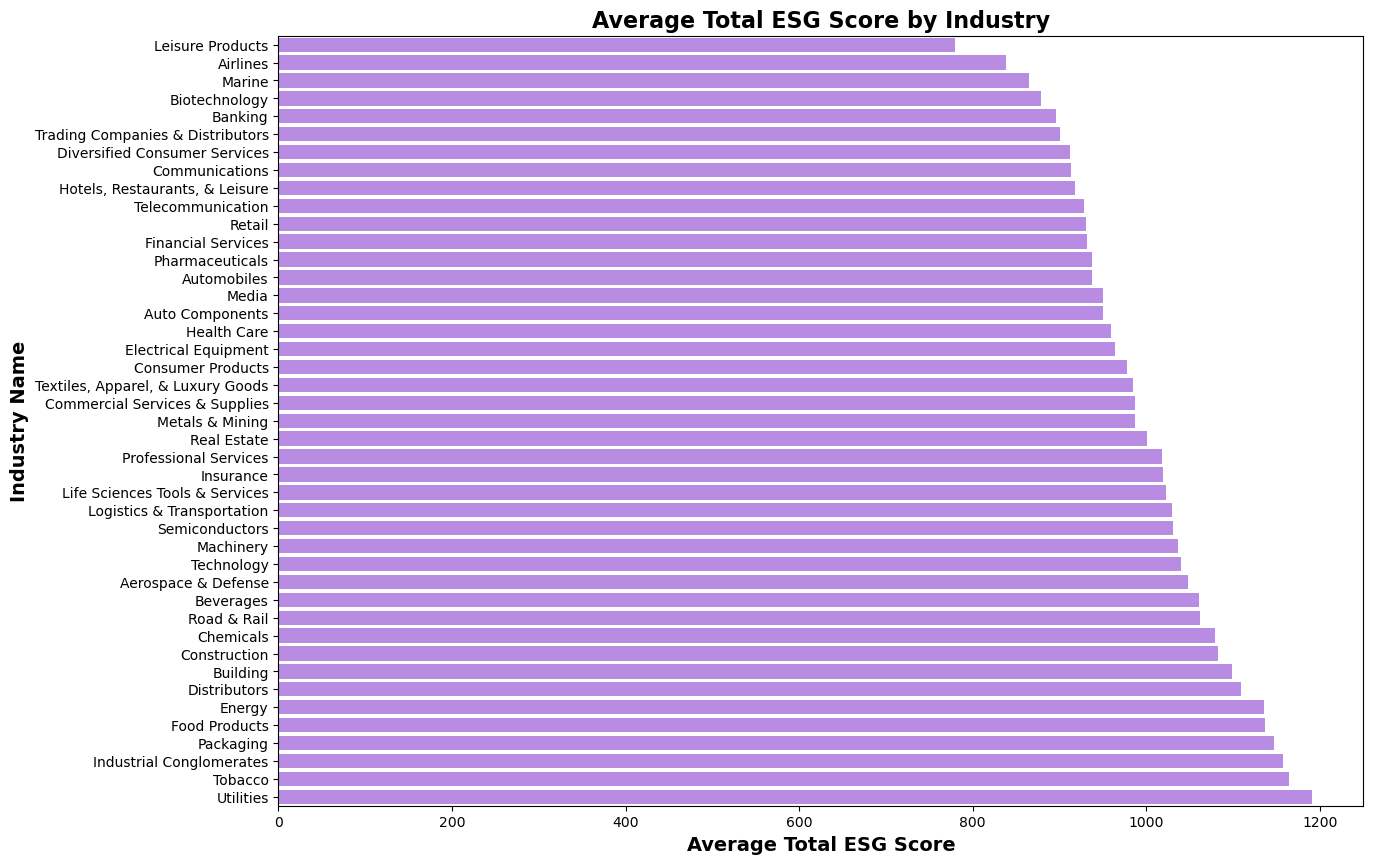

In [13]:
plt.figure(figsize = (14, 10))
sns.barplot(x = 'Average Total ESG Score', y = 'Industry', data = avg_esg_by_industry, color = "#b97df3")
plt.title('Average Total ESG Score by Industry', horizontalalignment = 'center', fontsize = 16, fontweight = 'bold', )
plt.xlabel('Average Total ESG Score', fontsize = 14, fontweight = 'bold')
plt.ylabel('Industry Name', fontsize = 14, fontweight = 'bold')
plt.show()

interestingly (and somewhat predictably) - the industries with the lowest ESG scores are Leisure Products, Airlines, Marine, Biotechnology, and Banking. the industries with the highest ESG scores are Utilities, Tobacco, Industrial Conglomerates, Packaging, and Industrial Conglomerates.

future steps: sort different industries by just Environmental score, just Social score, and just Governance score to see if these differ significantly.

In [23]:
avg_enviro_by_industry = merged_df.groupby('industry')['environment_score'].mean().reset_index()
avg_enviro_by_industry.columns = ['Industry', 'Average Environmental Score']

avg_enviro_by_industry = avg_enviro_by_industry.sort_values(by = 'Average Environmental Score', ascending = False)
print("best average Environment scores")
print(avg_enviro_by_industry.head(6))

avg_enviro_by_industry = avg_enviro_by_industry.sort_values(by = 'Average Environmental Score', ascending = True)
print("\nworst average Environment scores")
print(avg_enviro_by_industry.head(6))

best average Environment scores
                    Industry  Average Environmental Score
42                 Utilities                   550.966667
21  Industrial Conglomerates                   534.666667
30                 Packaging                   530.000000
13              Distributors                   525.000000
16                    Energy                   522.555556
18             Food Products                   517.076923

worst average Environment scores
                            Industry  Average Environmental Score
23                  Leisure Products                   252.333333
27                            Marine                   305.333333
6                      Biotechnology                   315.210526
41  Trading Companies & Distributors                   319.000000
1                           Airlines                   326.714286
4                            Banking                   341.000000


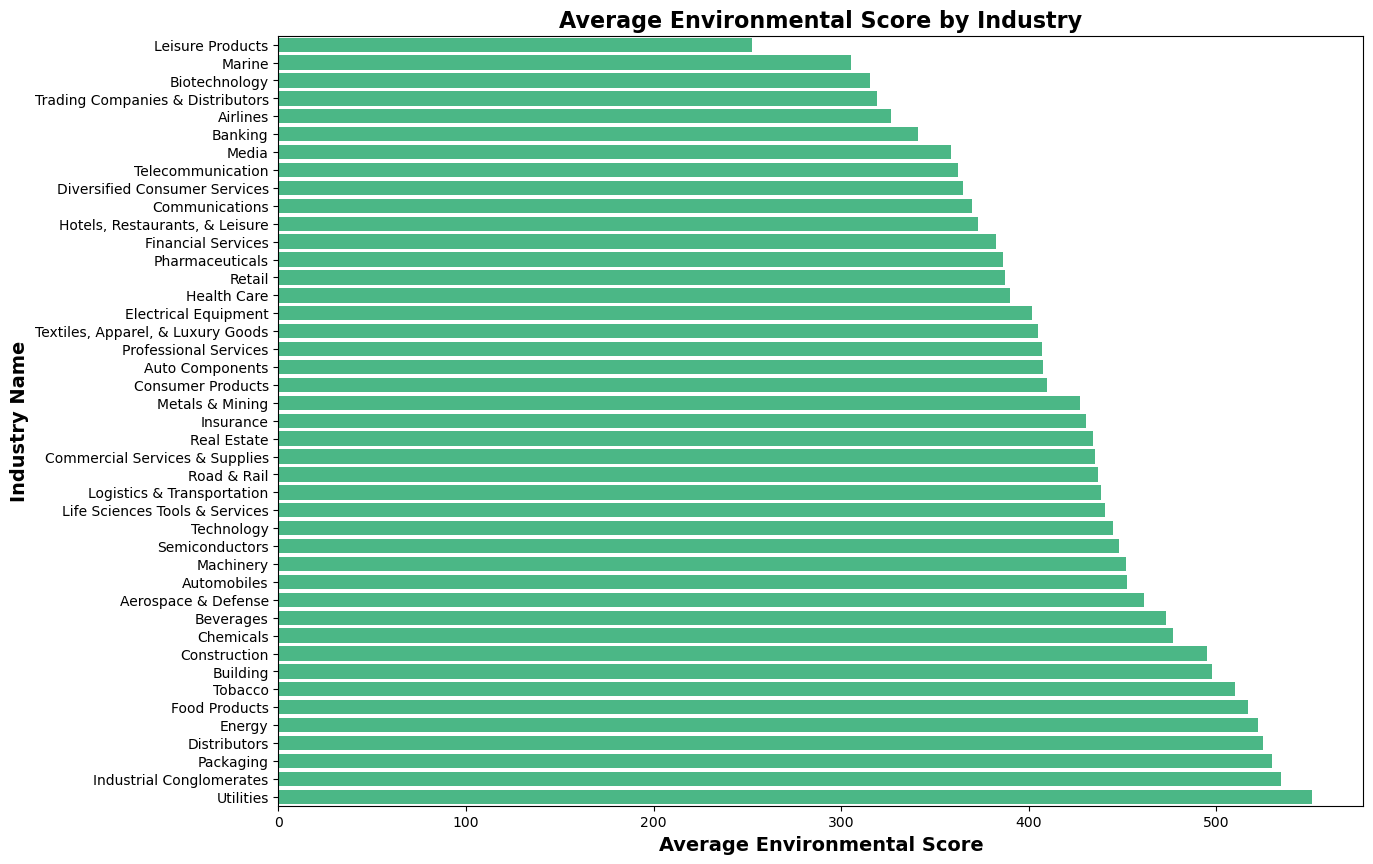

In [24]:
plt.figure(figsize = (14, 10))
sns.barplot(x = 'Average Environmental Score', y = 'Industry', data = avg_enviro_by_industry, color = "#39c988")
plt.title('Average Environmental Score by Industry', horizontalalignment = 'center', fontsize = 16, fontweight = 'bold', )
plt.xlabel('Average Environmental Score', fontsize = 14, fontweight = 'bold')
plt.ylabel('Industry Name', fontsize = 14, fontweight = 'bold')
plt.show()

the industries with the lowest Environmental scores are also Leisure Products, Marine, Biotechnology, Trading Companies & Distributors, and Airlines. the industries with the highest Environmental scores are also Utilities, Industrial Conglomerates, Packaging, Distributors, and Energy. 

In [21]:
avg_social_by_industry = merged_df.groupby('industry')['social_score'].mean().reset_index()
avg_social_by_industry.columns = ['Industry', 'Average Social Score']

avg_social_by_industry = avg_social_by_industry.sort_values(by = 'Average Social Score', ascending = False)
print("best average social scores")
print(avg_social_by_industry.head(6))

avg_social_by_industry = avg_social_by_industry.sort_values(by = 'Average Social Score', ascending = True)
print("\nworst average social scores")
print(avg_social_by_industry.head(6))

best average social scores
                            Industry  Average Social Score
42                         Utilities            357.400000
41  Trading Companies & Distributors            335.000000
35                       Road & Rail            329.400000
40                           Tobacco            327.000000
30                         Packaging            322.666667
21          Industrial Conglomerates            318.000000

worst average social scores
            Industry  Average Social Score
3        Automobiles            236.333333
23  Leisure Products            259.333333
1           Airlines            265.714286
6      Biotechnology            270.526316
10    Communications            271.500000
2    Auto Components            272.500000


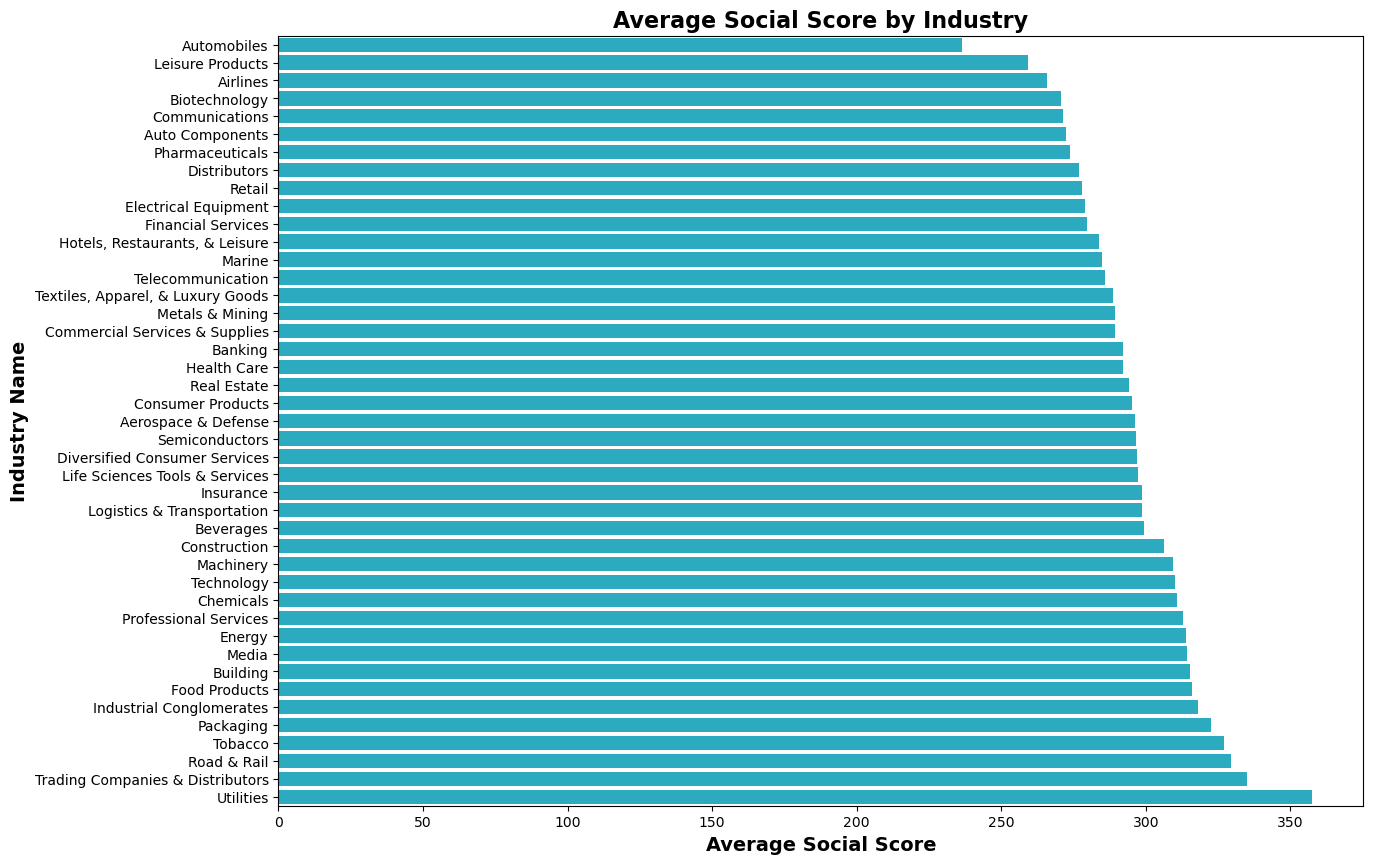

In [22]:
plt.figure(figsize = (14, 10))
sns.barplot(x = 'Average Social Score', y = 'Industry', data = avg_social_by_industry, color = "#13bcd8")
plt.title('Average Social Score by Industry', horizontalalignment = 'center', fontsize = 16, fontweight = 'bold', )
plt.xlabel('Average Social Score', fontsize = 14, fontweight = 'bold')
plt.ylabel('Industry Name', fontsize = 14, fontweight = 'bold')
plt.show()

the industries with the lowest Social scores are Automobiles, Leisure Products, Airlines, Biotechnology, and Communications. the industries with the highest Social scores are also Utilities, Trading Companies & Distributors, Road & Rail, Tobacco, and Packaging.

In [27]:
avg_gov_by_industry = merged_df.groupby('industry')['governance_score'].mean().reset_index()
avg_gov_by_industry.columns = ['Industry', 'Average Governance Score']

avg_gov_by_industry = avg_gov_by_industry.sort_values(by = 'Average Governance Score', ascending = False)
print("best average governance scores")
print(avg_gov_by_industry.head(6))

avg_gov_by_industry = avg_gov_by_industry.sort_values(by = 'Average Governance Score', ascending = True)
print("\nworst average governance scores")
print(avg_gov_by_industry.head(6))

best average governance scores
                    Industry  Average Governance Score
40                   Tobacco                328.000000
13              Distributors                307.666667
21  Industrial Conglomerates                304.333333
18             Food Products                303.076923
16                    Energy                299.611111
32     Professional Services                298.600000

worst average governance scores
                            Industry  Average Governance Score
1                           Airlines                246.285714
41  Trading Companies & Distributors                246.666667
3                        Automobiles                249.333333
14     Diversified Consumer Services                250.000000
20    Hotels, Restaurants, & Leisure                260.913043
9     Commercial Services & Supplies                262.200000


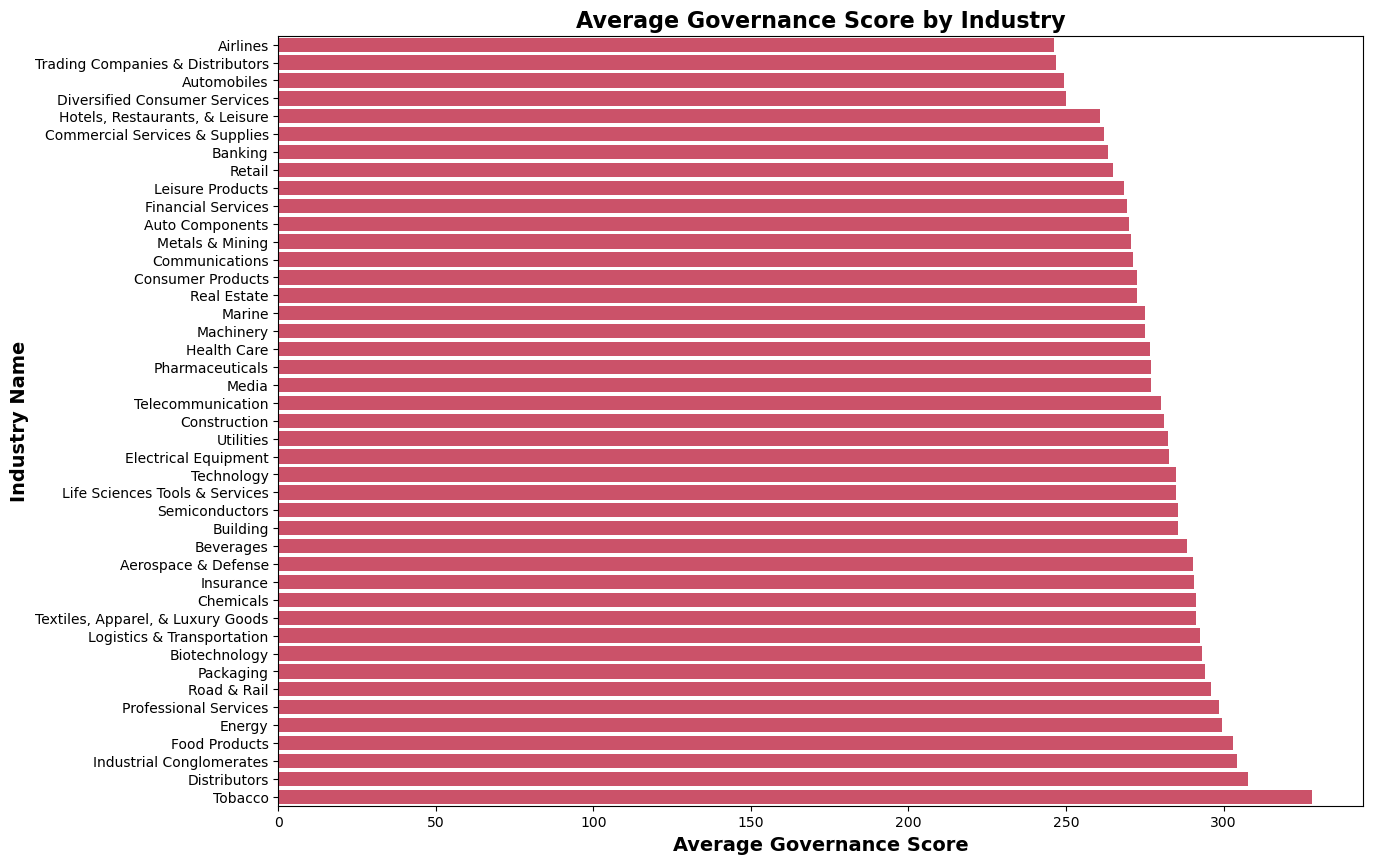

In [28]:
plt.figure(figsize = (14, 10))
sns.barplot(x = 'Average Governance Score', y = 'Industry', data = avg_gov_by_industry, color = "#df3e5d")
plt.title('Average Governance Score by Industry', horizontalalignment = 'center', fontsize = 16, fontweight = 'bold', )
plt.xlabel('Average Governance Score', fontsize = 14, fontweight = 'bold')
plt.ylabel('Industry Name', fontsize = 14, fontweight = 'bold')
plt.show()

the industries with the lowest Governance scores are Airlines, Trading Companies & Distributors, Automobiles, Diversified Consumer Services, and Hotels, Restaurants, & Leisure. the industries with the highest Governance scores are also Tobacco, Distributors, Industrial Conglomerates, Food Products, and Tobacco.

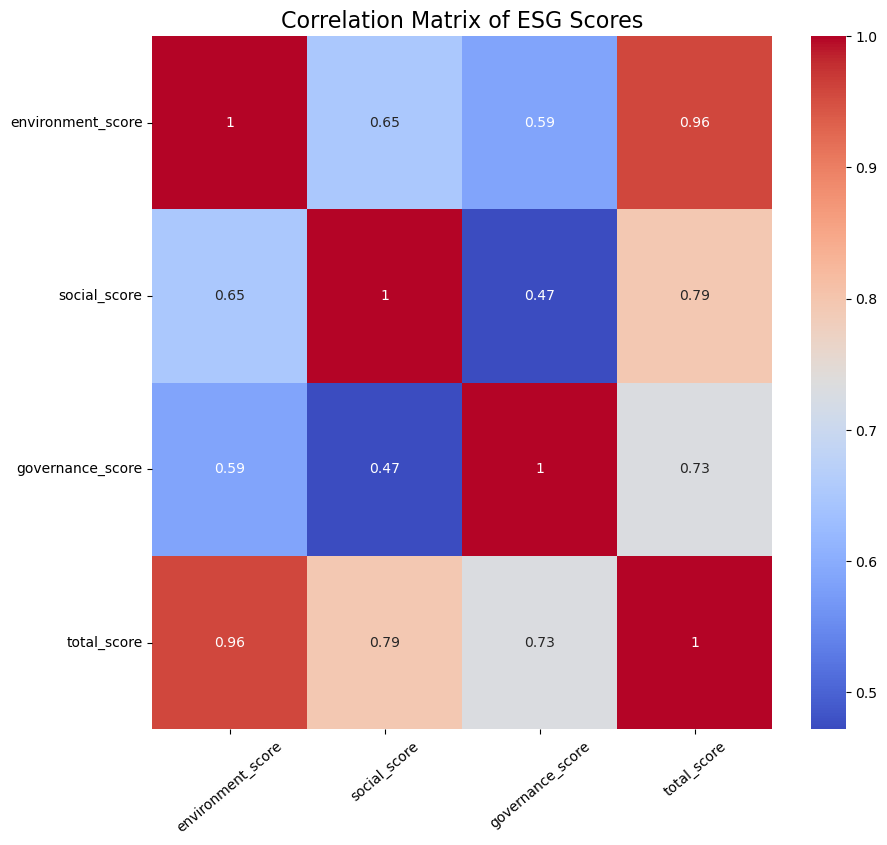

In [38]:
score_columns = ['environment_score', 'social_score', 'governance_score', 'total_score']
corr_matrix = merged_df[score_columns].corr()

plt.figure(figsize = (10, 9))
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm')
plt.title('Correlation Matrix of ESG Scores', fontsize = 16)
plt.xticks(rotation = 40)
plt.yticks(rotation = 0)
plt.show()

it seems like total ESG score is most closely correlated with environmental score, as compared to social or governance score, but all 3 have a pretty strong correlation coefficient. environment and social score also have the strongest correlation between the pairs of the 3.

#### part two

C:\Users\anush\AppData\Local\Temp\ipykernel_40276\990931122.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=merged_df, x='environment_level', y='governance_score', palette='muted')


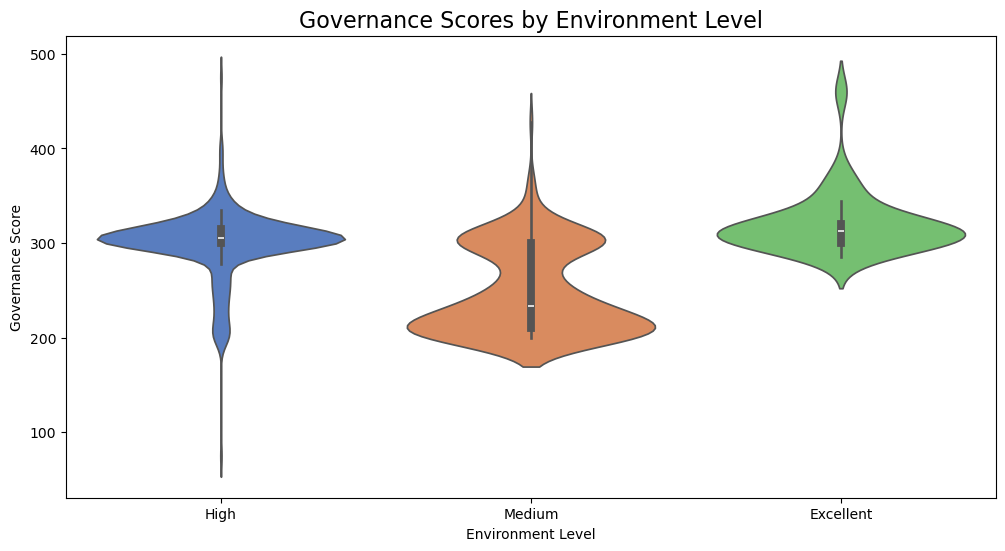

In [39]:
#Violin Plot: Governance Score by Environment Level
plt.figure(figsize=(12, 6))
sns.violinplot(data=merged_df, x='environment_level', y='governance_score', palette='muted')
plt.title('Governance Scores by Environment Level', fontsize=16)
plt.xlabel('Environment Level')
plt.ylabel('Governance Score')
plt.show()

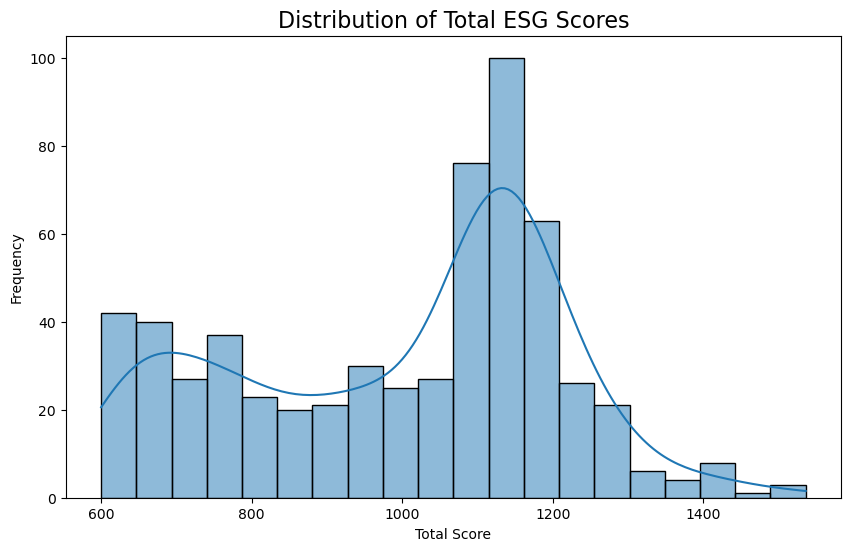

In [40]:
# Plot the distribution of total_score
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['total_score'], kde=True, bins=20)
plt.title('Distribution of Total ESG Scores', fontsize=16)
plt.xlabel('Total Score')
plt.ylabel('Frequency')
plt.show()

C:\Users\anush\AppData\Local\Temp\ipykernel_40276\3286590119.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_df, x='total_grade', y='total_score', palette='Set2')


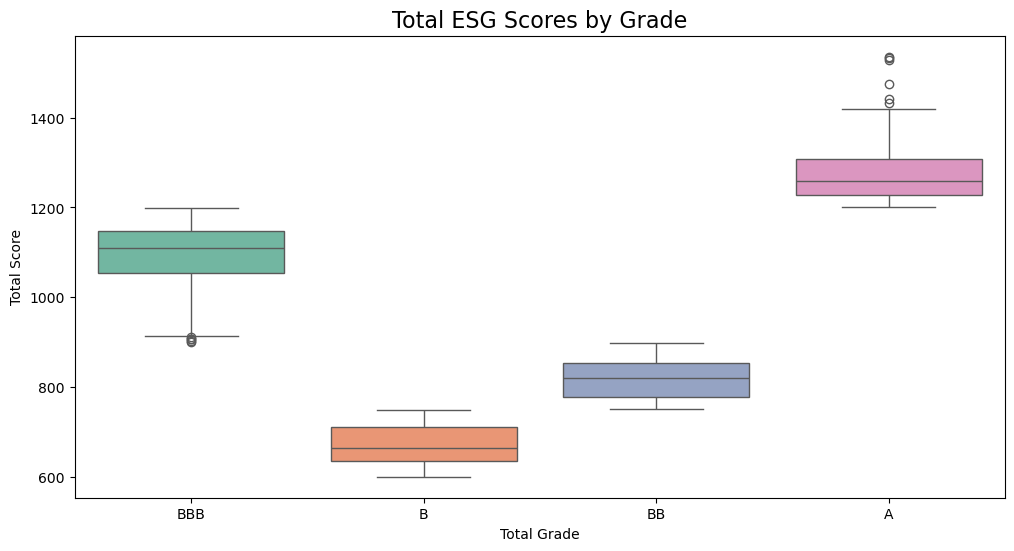

In [41]:
#Boxplot of Total Scores by Total Grade
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_df, x='total_grade', y='total_score', palette='Set2')
plt.title('Total ESG Scores by Grade', fontsize=16)
plt.xlabel('Total Grade')
plt.ylabel('Total Score')
plt.show()

C:\Users\anush\AppData\Local\Temp\ipykernel_40276\3739256297.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=merged_df, x='total_score', y='percentage_change', palette='coolwarm')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


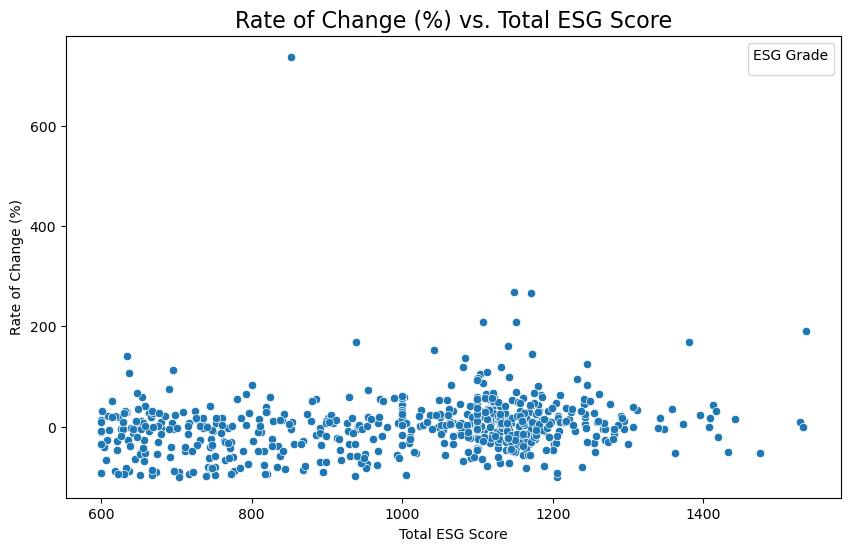

In [45]:
#Scatter Plot: Rate of Change vs. Total ESG Score
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='total_score', y='percentage_change', palette='coolwarm')
plt.title('Rate of Change (%) vs. Total ESG Score', fontsize=16)
plt.xlabel('Total ESG Score')
plt.ylabel('Rate of Change (%)')
plt.legend(title="ESG Grade", loc='upper right')
plt.show()

C:\Users\anush\AppData\Local\Temp\ipykernel_40276\1738742317.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_df, x='environment_grade', y='percentage_change', palette = 'Set3')


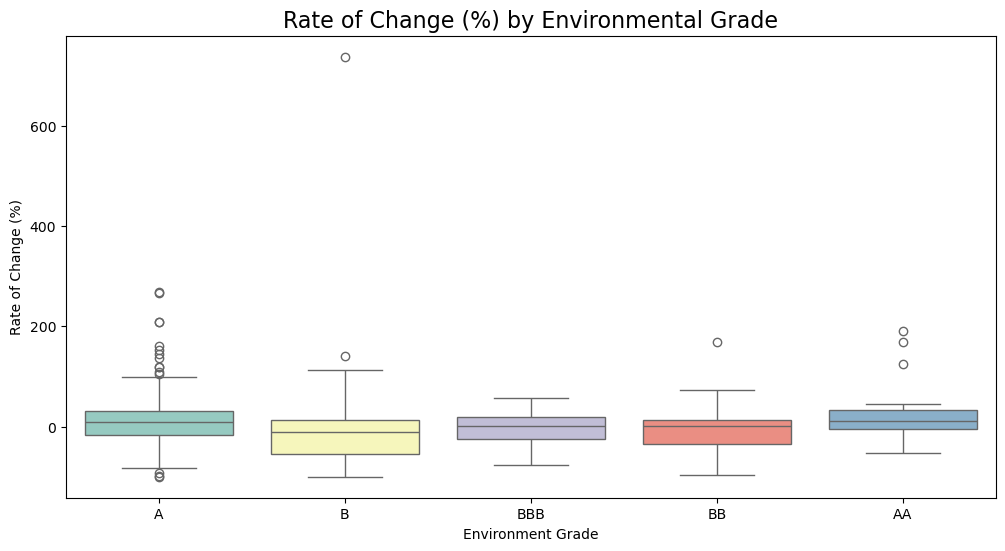

In [49]:
#Boxplot: Rate of Change by Environment Grade
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_df, x='environment_grade', y='percentage_change', palette = 'Set3')
plt.title('Rate of Change (%) by Environmental Grade', fontsize=16)
plt.xlabel('Environment Grade')
plt.ylabel('Rate of Change (%)')
plt.show()


C:\Users\anush\AppData\Local\Temp\ipykernel_40276\1518618962.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=merged_df, x='social_grade', y='percentage_change', palette='muted')


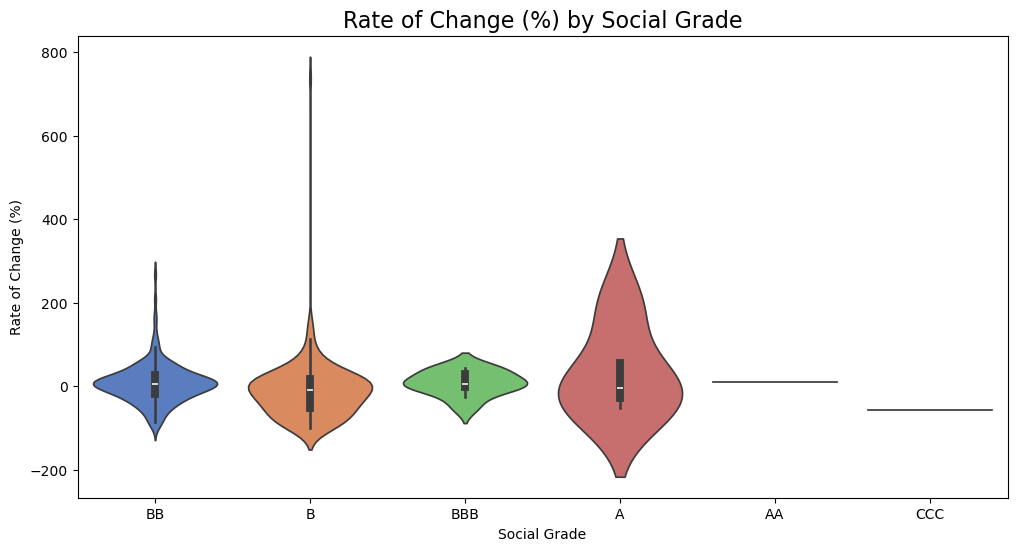

In [51]:
#Violin Plot: Rate of Change by Social Grade
plt.figure(figsize=(12, 6))
sns.violinplot(data=merged_df, x='social_grade', y='percentage_change', palette='muted')
plt.title('Rate of Change (%) by Social Grade', fontsize=16)
plt.xlabel('Social Grade')
plt.ylabel('Rate of Change (%)')
plt.show()


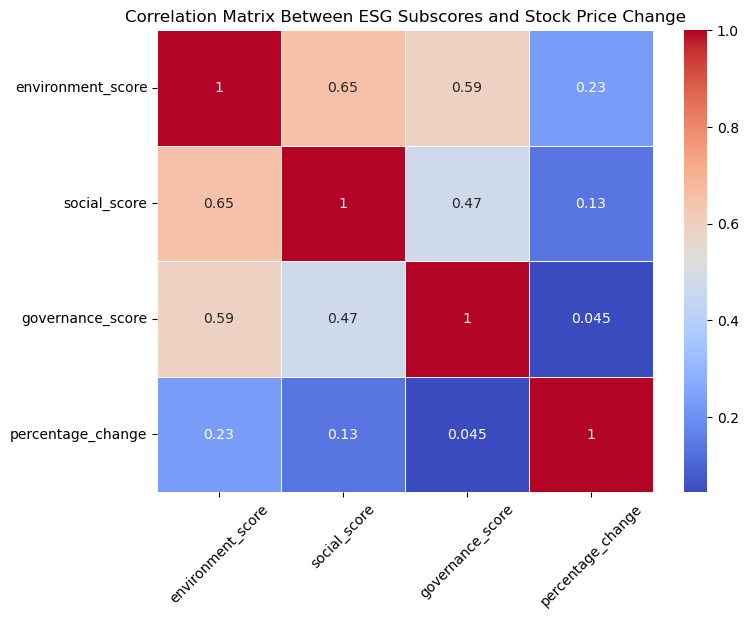

Correlation between Environmental Score and Rate of Change (%): 0.228
Correlation between Social Score and Rate of Change (%): 0.135
Correlation between Governance Score and Rate of Change (%): 0.045


In [52]:
correlation_matrix=merged_df[['environment_score', 'social_score', 'governance_score', 'percentage_change']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Between ESG Subscores and Stock Price Change')
plt.xticks(rotation=45)

plt.show()

correlation_environment = merged_df['environment_score'].corr(merged_df['percentage_change'])
correlation_social = merged_df['social_score'].corr(merged_df['percentage_change'])
correlation_governance = merged_df['governance_score'].corr(merged_df['percentage_change'])

print(f'Correlation between Environmental Score and Rate of Change (%): {correlation_environment:.3f}')
print(f'Correlation between Social Score and Rate of Change (%): {correlation_social:.3f}')
print(f'Correlation between Governance Score and Rate of Change (%): {correlation_governance:.3f}')


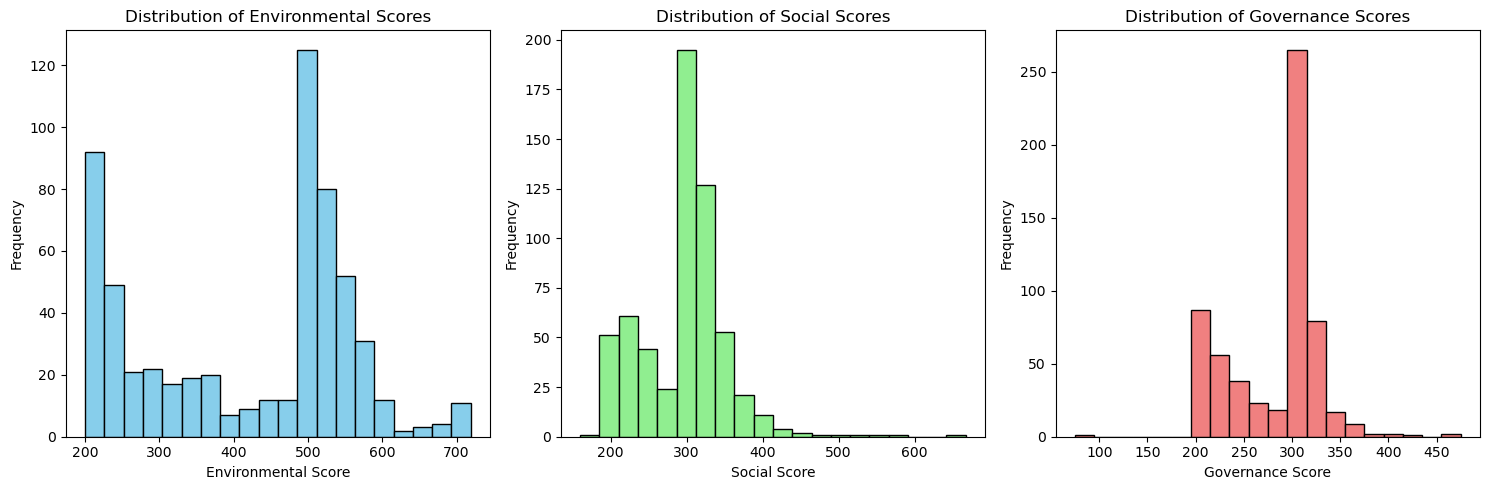

In [53]:
# Plot histograms for each ESG subscore
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(merged_df['environment_score'].dropna(), bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Environmental Score')
plt.ylabel('Frequency')
plt.title('Distribution of Environmental Scores')

plt.subplot(1, 3, 2)
plt.hist(merged_df['social_score'].dropna(), bins=20, color='lightgreen', edgecolor='black')
plt.xlabel('Social Score')
plt.ylabel('Frequency')
plt.title('Distribution of Social Scores')

plt.subplot(1, 3, 3)
plt.hist(merged_df['governance_score'].dropna(), bins=20, color='lightcoral', edgecolor='black')
plt.xlabel('Governance Score')
plt.ylabel('Frequency')
plt.title('Distribution of Governance Scores')

plt.tight_layout()
plt.show()


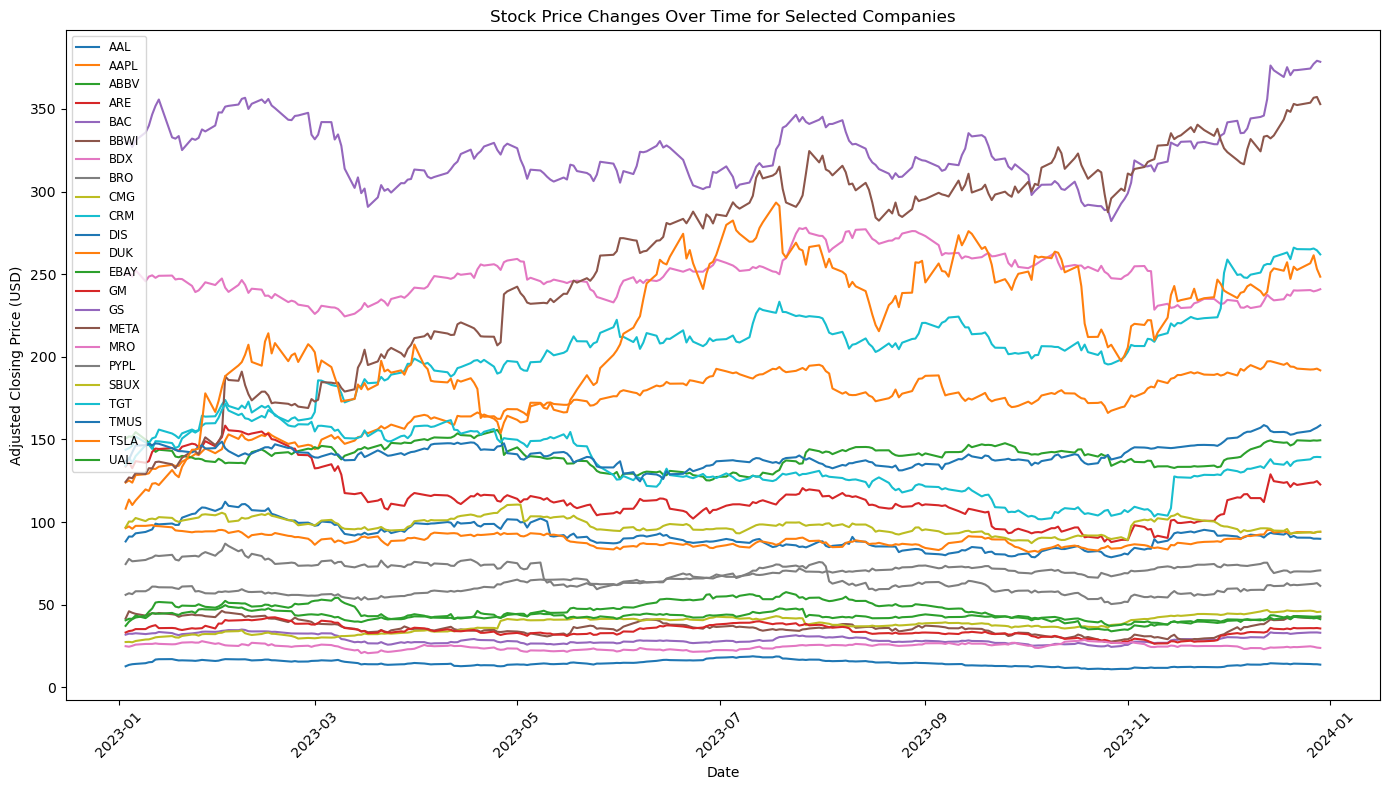

In [55]:
data = yf.download(list(sample_companies['ticker']), start='2023-01-01', end='2024-01-01', progress = False)['Adj Close']
        

plt.figure(figsize=(14, 8))
for ticker in data.columns:
    plt.plot(data.index, data[ticker], label=ticker)

plt.xlabel('Date')
plt.ylabel('Adjusted Closing Price (USD)')
plt.title('Stock Price Changes Over Time for Selected Companies')
plt.legend(loc='upper left', fontsize='small')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [57]:
X = merged_df[['environment_score', 'social_score','governance_score']]   # Independent variables
y = merged_df['percentage_change']   # Dependent variable

model = LinearRegression().fit(X, y)
print(f"Environmental Score Coefficient: {model.coef_[0]}")
print(f"Social Score Coefficient: {model.coef_[1]}")
print(f"Governance Score Coefficient: {model.coef_[2]}")
print(f"Intercept: {model.intercept_}")


Environmental Score Coefficient: 0.12790451882141235
Social Score Coefficient: -0.003544557504087607
Governance Score Coefficient: -0.16737576126736387
Intercept: -4.705639073387029


### Regression Coefficients Interpretation

For every 1-unit increase in the Environmental score (assuming all other factors remain constant), the stock return is expected to increase by 0.1079 units. The positive coefficient suggests that higher Environmental scores are associated with better stock performance (or higher returns).

For every 1-unit increase in the Social score (with other variables constant), the stock return is expected to decrease by 0.0237 units. The negative coefficient indicates that better Social scores might be associated with lower stock performance, but generally, since the coefficient is so close to 0, Social scores seem to have little impact on stock performance.

For every 1-unit increase in the Governance score (with other variables constant), stock return is expected to decrease by 0.0750 units. This negative coefficient suggests that improvements in governance (e.g., stricter regulation or more ethical practices) are associated with slightly lower stock returns. This could imply that governance improvements come at a financial cost.


In [58]:
esg_corr = merged_df.loc[:, ['environment_score', 'social_score',
                                'governance_score']] 
print(esg_corr.corr(numeric_only=True))

                   environment_score  social_score  governance_score
environment_score           1.000000      0.651165          0.587293
social_score                0.651165      1.000000          0.471923
governance_score            0.587293      0.471923          1.000000


In [59]:
print(esg_corr.cov(numeric_only=True))

                   environment_score  social_score  governance_score
environment_score       20153.402446   5210.459124       3968.944900
social_score             5210.459124   3177.032496       1266.275200
governance_score         3968.944900   1266.275200       2266.171483


---

### __Questions for Reviewers__

1. Does it seem like we have enough columns in merged_df and sample_companies to satisfy the complexity requirement for the project? Does our research question also seem complex enough?
   
2. Is there any advice or recommended steps to follow in creating our sample_companies dataset from the population? Should we try doing a random sample of 1 company from each industry? (how many industries should we actually take samples from to have a meaningful project then?) We were also thinking of stratifying our sample to include all of the different ESG grades. Another option is picking the biggest company (measured probably by end_price) from each industry - do any of these methods sound more robust than the other ones? (as a reminder - we have one big dataset, merged_df with 600 companies that we did some EDA with, but we also want to include a smaller sample dataset so we can look at some individual companies as well. the purpose of this smaller dataset would be then to observe trends on a company-level, and study the metrics of our research question on this smaller scale). Also - would it be valid to maybe pick a few companies within the same industry (like the 20 biggest companies in the technology industry) for this sample instead? We could then look at how ESG ratings and stock performance differs within an industry itself. 
   
3. How many visualizations (or like data analysis chunks) recommended for the final project? (ballpark range would be helpful, or will we get to look at some examples of a completed project later?)

4. Do the visualizations we currently have seem like they're on the right path for the final phases?
   
5. Regarding the visualizations and chunks we have made for our EDA so far: should we further explore these specific visualizations more in depth? Or should we expand our DA to other variables in the datasets that we maybe haven't used yet?